# TDEM Step off experiment

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This notebook was used to produce Figure 7 in Heagy and Oldenburg (2018)

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [1]:
# !pip install -r ../requirements.txt

In [2]:
# core python
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
from scipy.spatial import cKDTree
import os
import tarfile
import ipywidgets


# SimPEG, discretize
import discretize
from discretize import utils
from SimPEG.EM import TDEM
from SimPEG import Utils, Maps
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casingSim

%matplotlib inline

In [3]:
use_downsampled_results = True
rerun = False

## model parameters

In [4]:
simDir = "TDEM_fields_response_1km"
simDir_background = "TDEM_fields_response_1km_background"

In [5]:
sigma_air = 1e-5
sigma_back = 1e-2
sigma_casing = sigma_back
sigma_casing = 1e6

casing_diameter = 10e-2  
casing_t = 10e-3

mur_casing = 1.
casing_l = 1000
csz = 2.5 

In [6]:
src_a = np.r_[casing_diameter / 2., np.pi/2, 0.]
src_b = np.r_[casing_l, np.pi/2, 0.]

In [7]:
model = casingSim.model.CasingInHalfspace(
    directory = simDir, 
    casing_d = casing_diameter,  # I use diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_back,
    src_a = src_a,
    src_b = src_b
)

In [8]:
timeSteps = [(1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 17)]

model.timeSteps = timeSteps
print(model.timeSteps.sum())
print(len(model.timeSteps))

0.20422
187


In [9]:
model.diffusion_distance(2e-1)

model_background = model.copy()
model_background.sigma_casing = model_background.sigma_back
model_background.simDir = simDir_background

In [10]:
model_names = ["casing", "background"]
model_dict = dict(zip(model_names, [model, model_background]))

## Mesh

In [11]:
hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

In [12]:
meshGen = casingSim.mesh.CasingMeshGenerator(
    directory = simDir, 
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = 100,
    domain_x = casing_l,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 8,
    npadz = 17,
    csz = csz,
#     pfz = 1.5,
)

509712


/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


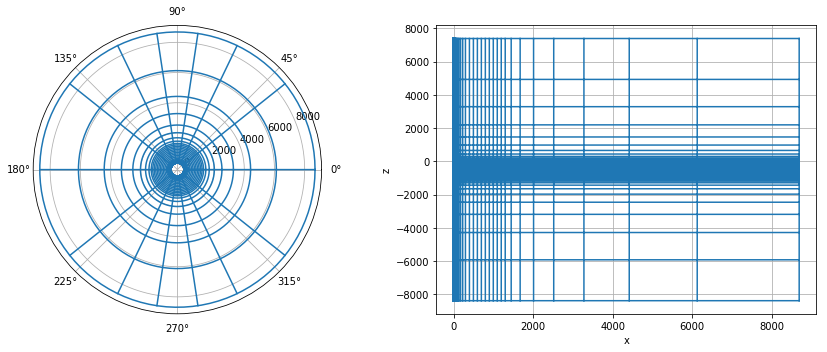

In [13]:
print(meshGen.mesh.nC)
ax = meshGen.mesh.plotGrid()
# ax[0].set_rlim([50., 100.])
# ax[1].set_ylim([])

## Physical Properties

In [14]:
physprops_dict = {
    key: casingSim.model.PhysicalProperties(
        modelParameters=m, meshGenerator=meshGen
    )
    for key, m in model_dict.items() 
}


In [15]:
from matplotlib.colors import LogNorm

[(-1250.0, 10.0), (-1250.0, 10.0)]

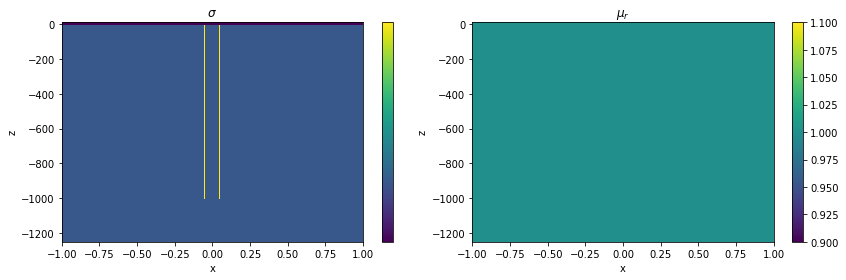

In [16]:
xlim = np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

ax = physprops_dict["casing"].plot(pcolorOpts = [{'norm':LogNorm()}, None])

[a.set_xlim(xlim) for a in ax]
[a.set_ylim(ylim) for a in ax]

## Survey

In [17]:
src = casingSim.sources.TopCasingSrc(
    directory=simDir, 
    modelParameters=model, 
    meshGenerator=meshGen,
)

(-10.0, 10.0)

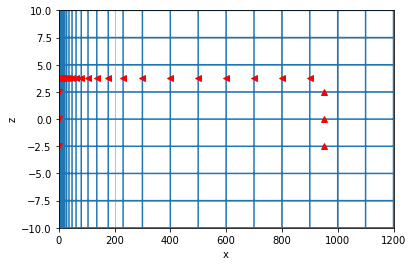

In [18]:
fig, ax = plt.subplots(1, 1)
meshGen.mesh.plotGrid(slice='theta', ax=ax)
src.plot(ax=ax)

ax.set_xlim([0., 1200.])
ax.set_ylim([-10., 10.])

(0.0, 60.0)

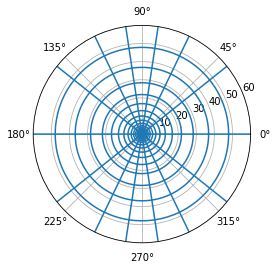

In [19]:
ax = meshGen.mesh.plotGrid(slice="z")
ax.set_rlim([0., 60.])

In [20]:
meshGen.mesh.vectorCCy[[3, 3+7]]*180/np.pi

array([  90.,  270.])

## Simulation

In [21]:
sim_dict = {
    key: casingSim.run.SimulationTDEM(
        directory=m.directory, 
        formulation='j',
        meshGenerator=meshGen,
        modelParameters=m,
        src=src, 
    )
    for key, m in model_dict.items()
}

uncomment the below to re-run the simulation

In [23]:
# uncomment to write out a simulation file to run on another machine
# for sim in sim_dict.values():
#     sim.write_py(include2D=False, includeDC=False)

In [ ]:
if rerun is True: 
    fields_dict = {}
    for key, sim in sim_dict.items():
        fields_dict[key] = sim.run()

# Load the results

In [25]:
if use_downsampled_results:
    f = "TDEM_fields_downsampled"
else:
    f = "TDEM_fields_response_1km"
    
if not os.path.isdir(f):
    download = Utils.download(
        "https://storage.googleapis.com/simpeg/heagy_2018_emcyl/{}.tar.gz".format(f)
    )  
    tar = tarfile.open(download, "r:*")
    tar.extractall()
    tar.close()

In [26]:
%%time

if use_downsampled_results:
    jSolution = np.load(f + os.path.sep + 'fields.npy')
    jSolution_background = np.load(f + os.path.sep + 'fields_background.npy')
    
    times = np.load(f + os.path.sep + 'times.npy')    
    timesteps = np.hstack(np.diff(times))
    
    for sim in sim_dict.values():
        sim.prob.timeSteps = timesteps
    
else: 
    jSolution = np.load(simDir + os.path.sep + 'fields.npy')
    jSolution_background = np.load(simDir_background + os.path.sep + 'fields.npy')
    

CPU times: user 640 ms, sys: 1.03 s, total: 1.67 s
Wall time: 2.8 s


In [27]:
%%time

if rerun is False: 
    # recreate the fields object
    fields_dict = {}

    for key, sim in sim_dict.items():
        sim.prob.model = physprops_dict[key].model
        fields_dict[key] = sim.prob.fieldsPair(sim.meshGenerator.mesh, sim.survey)
    
    fields_dict["casing"][:,'jSolution',:] = jSolution
    fields_dict["background"][:,'jSolution',:] = jSolution_background

CPU times: user 1min 48s, sys: 4.03 s, total: 1min 52s
Wall time: 2min 35s


# Plot Currents and Electric fields

In [29]:
viewer = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="background"
)

In [30]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":0.15,
        "theta_ind":3, 
        "view":"j"
    }
)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function ipywidgets.widgets.interaction.<lambda>>

In [31]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":1.5*model.casing_l,
        "theta_ind":3,
        "view":"j"
    }, 
    figwidth=12
)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function ipywidgets.widgets.interaction.<lambda>>

## Plan View 

In [32]:
viewer = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="background"
)

In [33]:
viewer.widget_depth_slice(
    fixed={"rotate": True, "figwidth":6, "use_aspect":True}, 
    defaults={"max_r":1500, "z_ind":400, "time_ind":1, "view":"j", "model_key":"casing"}
)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function ipywidgets.widgets.interaction.<lambda>>

# Print Figures

In [34]:
fields_dict2 = {}
sim_dict2 = {}

for key, sim in sim_dict.items():
    sim_dict2[key] = sim.copy()
    sim_dict2[key]._prob = sim._prob
    sim_dict2[key]._survey = sim._survey

if use_downsampled_results:
    f = "TDEM_fields_publication"
    if not os.path.isdir(f):
        download = Utils.download(
            "https://storage.googleapis.com/simpeg/heagy_2018_emcyl/{}.tar.gz".format(f)
        )  
        tar = tarfile.open(download, "r:*")
        tar.extractall()
        tar.close()
        
    jSolution = np.load(f + os.path.sep + 'fields.npy')
    jSolution_background = np.load(f + os.path.sep + 'fields_background.npy')
    
    times = np.load(f + os.path.sep + 'times.npy')    
    timesteps = np.hstack(np.diff(times))
    
    plt_times = np.arange(0, len(times))
    
    for sim in sim_dict2.values():
        sim.prob.timeSteps = timesteps

    # recreate the fields object
    for key, sim in sim_dict2.items():
        sim.prob.model = physprops_dict[key].model
        fields_dict2[key] = sim.prob.fieldsPair(sim.meshGenerator.mesh, sim.survey)    
        
    fields_dict2["casing"][:,'jSolution',:] = jSolution
    fields_dict2["background"][:,'jSolution',:] = jSolution_background
        
else:
    plt_times = [0, 10, 28, 73, 118, 136]
    fields_dict2 = fields_dict

In [35]:
from matplotlib import rcParams
from matplotlib import gridspec
rcParams['font.size'] = 16

In [36]:
viewer2 = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict2, fields_dict=fields_dict2, primary_key="background"
)

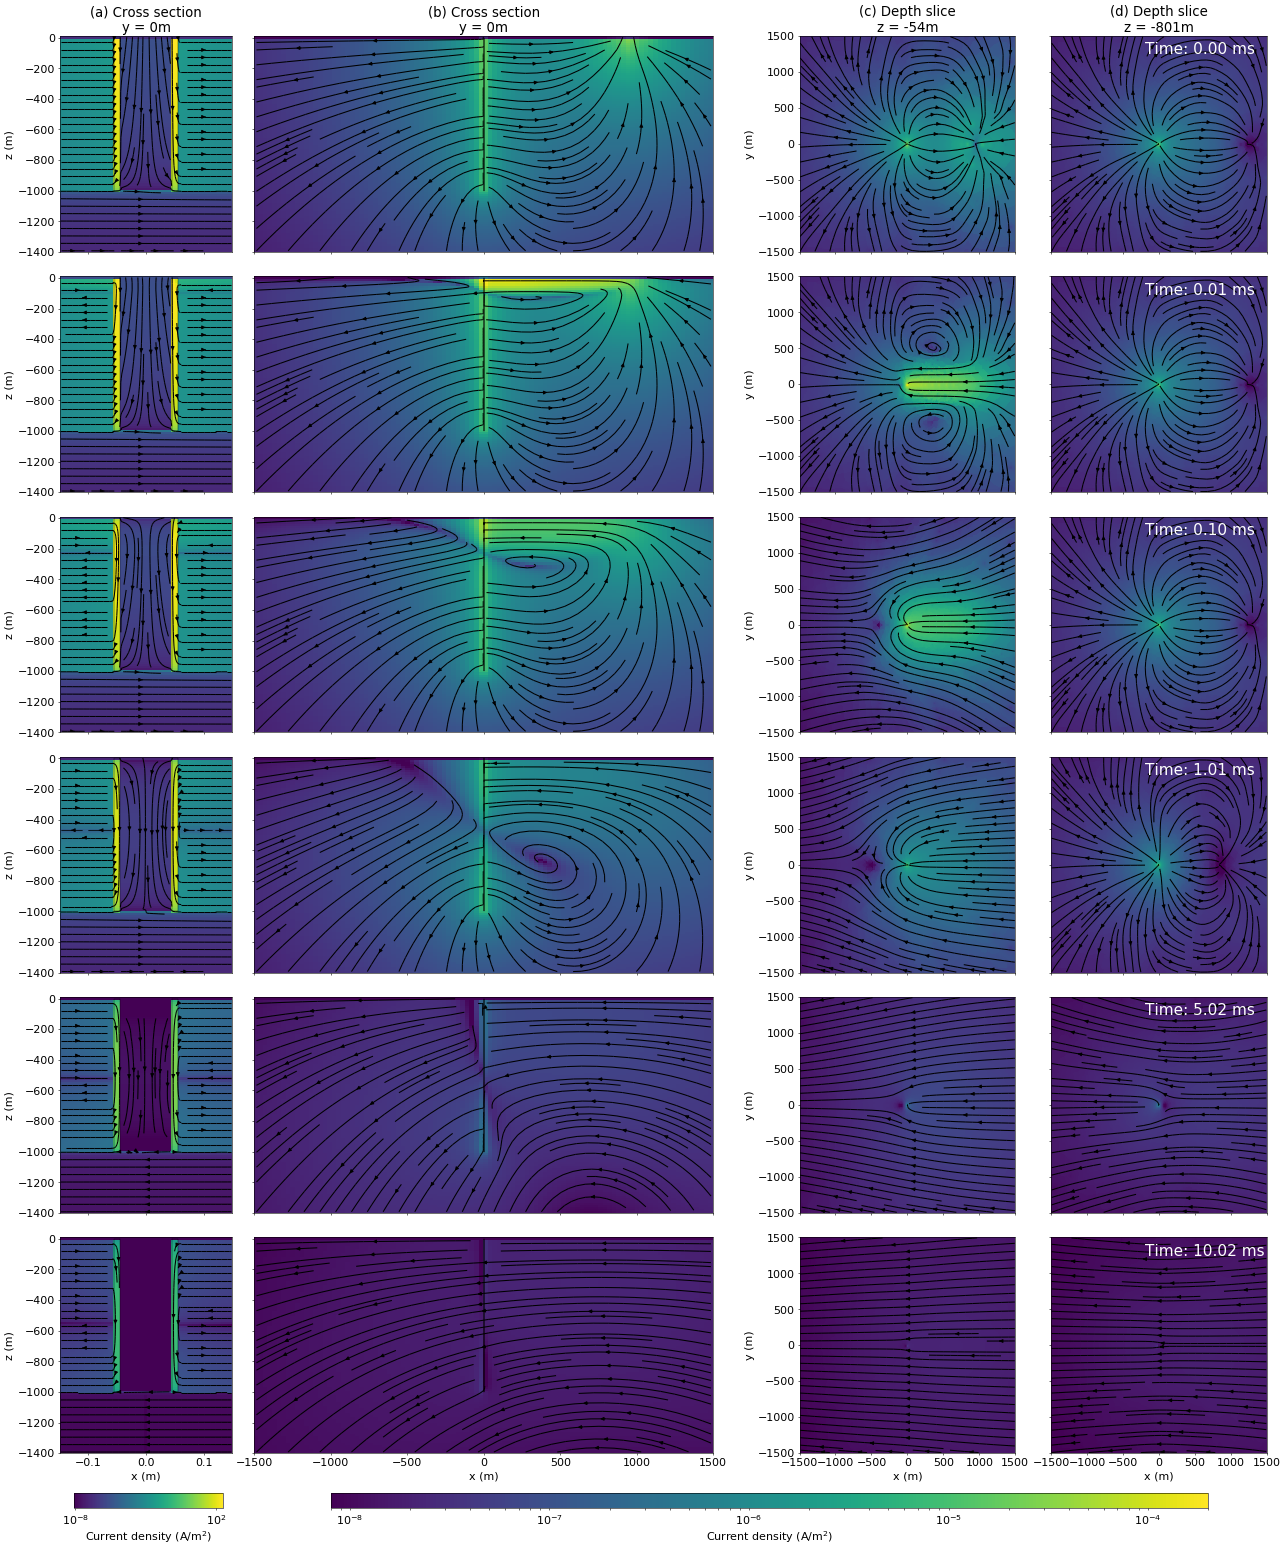

In [37]:
# mod = ['3D']
clim_max = 2e-4 
clim_min = 8e-9
clim = np.r_[clim_min, clim_max]

clim_max_casing = 3e2
clim_min_casing = 8e-9
clim_casing = np.r_[clim_min_casing, clim_max_casing]

max_depth = 1.4*casing_l
max_r_casing = 0.149
top=10.,

xlim = 1500.*np.r_[-1., 1.]

zinds = [400, 101]

x_ticks = [0, -500, -1000, -1500]

# fig, ax = plt.subplots(4, len(plt_times), figsize )

fig = plt.figure(figsize=(27, 5*len(plt_times)), dpi=50) 
fig.subplots_adjust(bottom=0.8)

gs = gridspec.GridSpec(len(plt_times), 4, width_ratios=[1, 4, 2, 2]) 
ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*4)]

for i, tind in enumerate(plt_times):
    
    ax0 = ax[i*4 + 1]
    ax1 = ax[i*4 + 2]
    ax2 = ax[i*4 + 3]
    ax3 = ax[i*4]
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax0, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key='casing', show_cb=False, use_aspect=True
    )
        
    
    # plot depth slice above
    for a, z_ind in zip([ax1, ax2], zinds):
        out = viewer2.plot_depth_slice(
            xlim=xlim, ylim=xlim, clim=clim,
            ax=a, z_ind=z_ind, model_key='casing', view='j',
            show_cb=False, time_ind=tind, rotate=True
        )
    
    ax2.text(-200, 1250, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=22)

    
    # zoomed in plot
    # currents in the formation
    out_casing = viewer2.plot_cross_section(
        ax=ax3, clim=clim_casing, zlim=np.r_[-max_depth, top],
        xlim=max_r_casing*np.r_[-1., 1.],
        view='j', theta_ind=3, time_ind=tind, 
        model_key='casing', show_cb=False
    )
    ax3.set_ylim(np.r_[-max_depth, top])
    ax3.set_ylabel('z (m)')
#     ax3.set_yticks(z_ticks)
    
    for a in [ax0, ax1, ax2, ax3]:
        a.set_title('')
        if a != ax3: 
            a.set_aspect(1)
            
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
        if a in [ax2, ax0]:
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))
    
        if a == ax1:
            a.set_ylabel('y (m)')
        
            
    if tind == 0:
        ax0.set_title('(b) Cross section\ny = 0m')
        ax1.set_title('(c) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[0]]))
        ax2.set_title('(d) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[1]])) 
        ax3.set_title('(a) Cross section\ny = 0m')
        
plt.tight_layout()

cbar_ax = fig.add_axes([0.25, -0.01, 0.65, 0.01])
cb = plt.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Current density (A/m$^2$)')

cbar_ax2 = fig.add_axes([0.06, -0.01, 0.11, 0.01])
cb2 = plt.colorbar(out_casing[0], cbar_ax2, orientation='horizontal')
cb2.set_label('Current density (A/m$^2$)')
cb2.set_ticks([1e-8, 1e2])
cb2.update_ticks()

plt.show()

In [38]:
# fig.savefig('tdem_currents', bbox_inches='tight', dpi=300)